# Daily SF Rona Report 

Author: Josh Myer &lt;josh@joshisanerd.com> <br/>
Date: 2022-07-18 <br/>
Version: 0.2<br/>
Status: Permanently in draft (living document dependent on not-officially-published data sources)

**NB: I have no affiliation with any data source used.**  I am just some random jackoff on the internet with python and decades of data analysis experience.  My degrees were in Linguistics and Mathematics, with no medical training beyond an incomplete first aid certification that would've expired a very long time ago.

This is a dashboard that combines data from [Stanford SCAN](https://soe-wbe-pilot.wl.r.appspot.com/charts#page=overview) and [SF.gov's COVID-19 data portal](https://sf.gov/resource/2021/covid-19-data-and-reports).

Please bear in mind that this is meant to be used by hand every day, so there's a bit of cruftiness that is acceptable but wouldn't fly in a Real System™.


## License

This notebook is released under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/), which is as close to "in the public domain" as you can get without being dead for some number of years.

Note that this code provides no license or permissions for the data sources used.  If you wish to use this "dashboard" for anything but personal use, I strongly recommend finding the relevant contacts at SF.gov and Stanford's SCAN project.

Beyond that, please use this code to help inform your own "personal responsibility" for the society-wide structural failure we're all living through together.

## Data source backgrounds

The first, and easier, data source here is the official SF tracking data.  They publish this on [SF.gov: COVID-19 Data and reports](https://sf.gov/resource/2021/covid-19-data-and-reports).  This data is published with very well-established expectations about availability: it's got 5 day lags on most data, with the final 3 days of that being provisional.  In general, those last three days are complete when reported, but there are times when the final day or two of data are incomplete.  This data is all published via Microsoft Power BI™ dashboards, which includes an explicit CSV export mechanism.  These URLs haven't changed in many months, but there's zero guarantee they won't have changed by the time you're reading this.  I apologize if they're now defunct, as you will have to interact with Microsoft Power BI™ to find the new URLs.

The other data source here is Stanford SCAN's pilot program.  I highly recommend viewing the video embedded in [the Stanford SCAN About page](https://soe-wbe-pilot.wl.r.appspot.com/charts#page=about) to understand their dataset.  This data is collected by sampling sewage from the inflow at treatment plants.  More importantly, it's normalized by extracting RNA for a harmless but common virus in human feces along with the disease virus RNA.  This allows them to normalize the data by comparing the amount of the harmless virus extracted; I colloquially refer to this dataset as "poop-normalized," to make it clear that rainwater, irrigation, etc etc etc will have minimal impact on the data.

## Other notes

I'm publishing this because I get lots of questions about it from the very small number of supernerds who see my daily-ish graphs.  To be blunt, after many months of this, I'm getting tired of it, and now only publish it every week or so.

# Changelog

### v0.2: 2022-07-18: Move to N-PMMoV only

In light of the spike protein variation in variants, I'm pro-actively moving the sewage data from N+S averages to just the N values.  The 7-day average is still used.  This will make older data a bit jumpier/noisier, and may require re-evaluation of previous outliers (some of them my have been S-PMMoV outliers only).

We continue to compute the old N+S average (`ns_mean_rtrimmed7`) as before.  We also continue to compute our own rolling average (stored in `rr_n_rolling7`), as we throw out outlier datapoints that upstream does not.

This update also adds a vertical line on the last day of SFUSD's regular session, per a personal bugaboo. (I tend to think that schools are where most of our untracked infections are happening, for a few different reasons.) 

Finally, this update fixes a dumb bug in the longitudinal sewage/cases plots.  When `plot_dots` was set to `True`, it plotted raw case counts, but the points it plotted for sewage data were the smoothed averages.  With this update, it now plots the raw data as appropriate (raw N, or (N+S)/2 if you're using the old metric).

### v0.1: 2022-06-04: Initial public release

I had been using this for many months prior to release.  Over that time, it smoothed out into something vaguely maintainable.  I finally got sick of running it myself, especially since my kid's school was nearly wrapping up for the year, and I no longer had any need to be hypervigilant.  Several of my friends were keen consumers of this data, however, so I wanted to ensure they could still run it.  Therefore, this was released on github.

In [1]:
%matplotlib inline

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

# I just updated to Ubuntu 22.04, and learned that they're finally
# actually deprecating pyplot.  When I started this dashboard many
# months ago, that wasn't the case.

# They're stealin' mah pyplot!
from matplotlib.pyplot import figure, xlim, ylim, title, \
                              xlabel, ylabel, legend, xticks, yticks, \
                              subplots, plot, scatter, axvline, \
                              axhline, axvspan, axhspan, xscale, yscale, text


import datetime

import pandas as pd

mpl.rcParams["figure.facecolor"] = "w" # Transparent backgrounds are hard to share
mpl.rcParams["figure.figsize"] = (8,4.5) # 16:9 aspect ratio for the fediverse

In [2]:
COLOR_WW = "tab:blue"
COLOR_CASES = "tab:red"
COLOR_TESTS = "tab:green"

# Whether to use N+S PMMoV data, or just N-PMMoV alone
USE_COMBINED_N_S_DATA = False

if USE_COMBINED_N_S_DATA:
    SEWAGE_KEY = "ns_mean_rtrimmed7"  # Original N+S average
    SEWAGE_LABEL = "N+S PMMoV 7d trailing avg"
    SEWAGE_RAW = "ns_mean_raw"
elif False:
    SEWAGE_KEY = "rr_n_rolling3"  # Let ourselves look for weekend hits
    SEWAGE_LABEL = "N PMMoV 3d trailing avg"
    SEWAGE_RAW = "N_PMMoV"
else:
    # 2022-07-18 Removing spike protein sequence, as it's highly variable in variants
    SEWAGE_KEY = "rr_n_rolling7" 
    SEWAGE_LABEL = "N PMMoV 7d trailing avg"
    SEWAGE_RAW = "N_PMMoV"

In [3]:
# Some helper functions for highlighting regions

def _vline(dt, ypos, txt, color="#ff6666", txt_offset=None, txt_align=None):
    axvline(dt, alpha=0.3, color=color)
    
    txt_align = txt_align or "right"
    txt_offset = txt_offset or -datetime.timedelta(days=4)
    
    text(dt+txt_offset, ypos,
         txt, 
         horizontalalignment=txt_align, color=color)

def _vspan(dt0, dt1, ypos, txt, color="#ff6666", txt_offset=None, txt_align=None):
    axvspan(dt0, dt1, alpha=0.3, color=color)
    
    txt_align = txt_align or "right"
    txt_offset = txt_offset or -datetime.timedelta(days=4)
    if txt_align == "right":
        txt_dt = dt0 + txt_offset
    elif txt_align == "left":
        txt_dt = dt1 + txt_offset
    elif txt_align == "center":
        txt_dt = (dt0+dt1)/2 + txt_offset
    
    
    text(txt_dt, ypos,
         txt, 
         horizontalalignment=txt_align, color=color)


# Data loading

This section loads the data and manually throws out sewage data with extreme outliers.  These outliers are determined by the very scientific "eyeball it" method.  I look for days where there's a spike up or down that doesn't fit in with the surrounding data and then filter.  Note that this requires at least two days' data *after* the datapoint in question to really believe, so you wind up with a bit of wiggle in previous days' results.

The SF.gov dataset is manually curated on their end, so we do not need to filter it.  (When the data makes no sense, it's due to mass human behavior, not lab technique.)

In [4]:
def _load_wastewater_data(target, outliers):
    '''Load the wastewater data from Stanford SCAN and preprocess it
    
    This loads the data from the web, filters down to the target facility, 
    and excludes hand-selected outliers.
    '''
    df_wastewater_all = pd.read_csv('https://storage.googleapis.com/soe-wwd-data/dashboard.csv')
    df_wastewater_all["dt"] = pd.to_datetime(df_wastewater_all.Date)
    df_wastewater = df_wastewater_all[df_wastewater_all.Plant == target]

    # These are days with pretty clear outliers
    # Include a day not in the dataset to avoid some pandas warnings about resetting indices
    for bogus_day in ["2001-01-01"] + outliers:
        df_wastewater = df_wastewater[df_wastewater.dt != pd.to_datetime(bogus_day)]

    df_wastewater.set_index("dt", inplace=True, drop=False)
    df_ww_rebuild = df_wastewater[["S_PMMoV", "N_PMMoV"]].rolling('7d', center=False).mean()

    df_wastewater["ns_mean_rtrimmed7"] = (df_ww_rebuild["S_PMMoV"] + df_ww_rebuild["N_PMMoV"])/2
    df_wastewater["ns_mean_raw"] = (df_wastewater["N_PMMoV"] + df_wastewater["S_PMMoV"])/2

    df_wastewater["rr_n_rolling7"] = df_ww_rebuild["N_PMMoV"]
    df_wastewater["rr_s_rolling7"] = df_ww_rebuild["S_PMMoV"]
  
    df_ww_rebuild3 = df_wastewater[["S_PMMoV", "N_PMMoV"]].rolling('3d', center=False).mean()
    df_wastewater["rr_n_rolling3"] = df_ww_rebuild["N_PMMoV"]
    df_wastewater["rr_s_rolling3"] = df_ww_rebuild["S_PMMoV"]

    return df_wastewater

wastewater_outliers = ["2022-03-07", "2022-04-04", "2022-04-10", "2022-04-23", 
                       "2022-05-01", "2022-05-31", "2022-06-24", "2022-06-27",
                       "2022-07-03", "2022-07-12", "2022-07-24", "2022-08-06",
                       "2022-08-10", "2022-08-12", "2022-08-18", "2022-08-31",
                       "2022-08-25", "2022-08-26", "2022-09-09", "2022-09-11",
                       "2022-11-05", "2022-11-10", "2022-11-18", "2022-11-30",
                       "2022-12-01", "2022-12-13",
                      ]
df_wastewater = _load_wastewater_data("Oceanside", wastewater_outliers)
df_wastewater.tail()

,Unnamed: 0,Plant,Sample,Date,Collection_Date,N_PMMoV,N_PMMoV_UCI,N_PMMoV_LCI,S_PMMoV,S_PMMoV_UCI,...,Noro_G2_PMMoV_rtrimmed5,Noro_G2_PMMoV_trimmed7,Noro_G2_PMMoV_rtrimmed7,dt,ns_mean_rtrimmed7,ns_mean_raw,rr_n_rolling7,rr_s_rolling7,rr_n_rolling3,rr_s_rolling3
dt,,,,,,,,,,,,,,,,,,,,,
2022-12-21,716,Oceanside,OSP700723,2022-12-21,December 21 2022,0.001249,0.001403,0.001095,0.000985,0.001135,...,0.015101,0.017901,0.014971,2022-12-21,0.001046,0.001117,0.001154,0.000939,0.001154,0.000939
2022-12-22,717,Oceanside,OSP700866,2022-12-22,December 22 2022,0.001056,0.001153,0.000959,0.000831,0.000925,...,0.016594,0.018389,0.015621,2022-12-22,0.001013,0.000943,0.001115,0.000911,0.001115,0.000911
2022-12-23,718,Oceanside,OSP700837,2022-12-23,December 23 2022,0.000980,0.001042,0.000919,0.000693,0.000739,...,0.020367,0.019359,0.017933,2022-12-23,0.000999,0.000837,0.001123,0.000876,0.001123,0.000876
2022-12-24,719,Oceanside,OSP700789,2022-12-24,December 24 2022,0.000981,0.001084,0.000878,0.000767,0.000863,...,0.020367,0.020232,0.017901,2022-12-24,0.000943,0.000874,0.001059,0.000826,0.001059,0.000826
2022-12-25,720,Oceanside,OSP700790,2022-12-25,December 25 2022,0.000432,0.000451,0.000412,0.000384,0.000401,...,0.020232,0.019861,0.018389,2022-12-25,0.000889,0.000408,0.001004,0.000775,0.001004,0.000775


In [5]:
def _load_sf_cases(path):
    '''Load the SF.gov case data
    
    This does a quick gut check on the final day's data: data is sometimes
    incompletely reported at the tail.  SF explicitly flags this in their 
    presentation, but it's more often that the final datapoint is actually
    complete, so we prefer to use it when we can.
    '''
    df_sf_csv = pd.read_csv(path)
    df_sf_csv["dt"] = pd.to_datetime(df_sf_csv["Specimen Collection Date"])
    df_sf_csv.set_index("dt", inplace=True, drop=False)
    df_sf_csv.sort_index(inplace=True)

    # If the last day's data seems to be incomplete, drop it for now
    new_cases_m1 = df_sf_csv["New Cases"][-1] 
    new_cases_m8 = df_sf_csv["New Cases"][-8]
    if new_cases_m1 / new_cases_m8 < 0.7:
        print(f"Warning: looks like the last day's data is incomplete!: {new_cases_m1} vs {new_cases_m8}")
        df_sf_csv = df_sf_csv.iloc[:-1]
    return df_sf_csv

df_cases = _load_sf_cases("https://data.sfgov.org/api/views/gyr2-k29z/rows.csv?accessType=DOWNLOAD")

df_cases.tail()

,Specimen Collection Date,New Cases,Cumulative Cases,Data As Of,Data Loaded At,dt
dt,,,,,,
2022-12-19,12/19/2022 12:00:00 AM,270,188693,12/28/2022 04:30:00 AM,12/28/2022 07:00:07 AM,2022-12-19
2022-12-20,12/20/2022 12:00:00 AM,179,188872,12/28/2022 04:30:00 AM,12/28/2022 07:00:07 AM,2022-12-20
2022-12-21,12/21/2022 12:00:00 AM,221,189093,12/28/2022 04:30:00 AM,12/28/2022 07:00:07 AM,2022-12-21
2022-12-22,12/22/2022 12:00:00 AM,151,189244,12/28/2022 04:30:00 AM,12/28/2022 07:00:07 AM,2022-12-22
2022-12-23,12/23/2022 12:00:00 AM,158,189402,12/28/2022 04:30:00 AM,12/28/2022 07:00:07 AM,2022-12-23


In [6]:
def _load_sf_tests(path):
    '''Load the SF.gov testing data
    
    This does a quick gut check on the final day's data: data is sometimes
    incompletely reported at the tail.  SF explicitly flags this in their 
    presentation, but it's more often that the final datapoint is actually
    complete, so we prefer to use it when we can.
    '''
    df_testing = pd.read_csv(path)
    df_testing["dt"] = pd.to_datetime(df_testing.specimen_collection_date)
    df_testing.set_index("dt", inplace=True, drop=False)
    df_testing.sort_index(inplace=True)

    # If the last day's data seems to be incomplete, drop it for now
    tests_m1 = df_testing["tests"][-1] 
    tests_m8 = df_testing["tests"][-8]
    if tests_m1 / tests_m8 < 0.7:
        print(f"Warning: looks like the last day's data is incomplete!: {tests_m1} vs {tests_m8}")
        df_testing = df_testing.iloc[:-1]

    return df_testing


df_testing = _load_sf_tests("https://data.sfgov.org/api/views/nfpa-mg4g/rows.csv?accessType=DOWNLOAD")

df_testing.tail()

,specimen_collection_date,tests,pos,pct,neg,indeterminate,Last Updated At,data_loaded_at,dt
dt,,,,,,,,,
2022-12-18,2022/12/18,927,117,0.126,810,0,12/28/2022 04:43:24 AM,12/28/2022 09:00:06 AM,2022-12-18
2022-12-19,2022/12/19,2685,342,0.128,2338,5,12/28/2022 04:43:24 AM,12/28/2022 09:00:06 AM,2022-12-19
2022-12-20,2022/12/20,2166,226,0.105,1933,7,12/28/2022 04:43:24 AM,12/28/2022 09:00:06 AM,2022-12-20
2022-12-21,2022/12/21,2164,255,0.118,1906,3,12/28/2022 04:43:24 AM,12/28/2022 09:00:06 AM,2022-12-21
2022-12-22,2022/12/22,2164,194,0.090,1964,6,12/28/2022 04:43:24 AM,12/28/2022 09:00:06 AM,2022-12-22


# Plots

There are kind of a lot of plots here.

## Wastewater levels plus reported case counts

This plots the wastewater levels alongside the reported case numbers. 

(18567.0, 19354.50949674859)

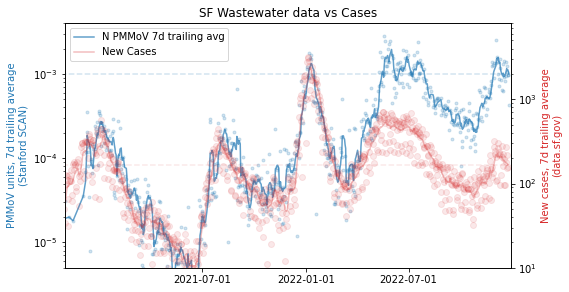

In [22]:
def _plot_ww_cases_long(plot_dots=False, figsize=None, ax1=None, xtick_downsample=3):
    '''Plot SF wastewater data versus SF's case data.
    
    plot_dots: whether or not to plot the raw case counts as dots
    figsize: size of the figure, as to plt.figure()
    ax1: the axis to use, None means to make a new one
    xtick_downsample: downsample the number of xticks by this
    
    This is the main plot I look at each day.  It shows the rolling trend for sewage
    levels alongside the repored case counts for SF.
    
    It has manually set x and y axes.  The x axis is scaled to focus in on the relevant
    bits of data.  The y axis scales are set to get the case data to visually track the
    sewage data, and to help the reader get a sense of scale.
    
    If you use this for other datasets, you will likely have to change the scales as
    appropriate for your data.  Look for SCALE TOUCHUPS to see where to do this.
    '''
    if ax1 is None:
        _, ax1 = plt.subplots(figsize=figsize)

    ns_colname = SEWAGE_KEY

    wwdata = df_wastewater[ns_colname]
    ln1 = ax1.plot(wwdata, alpha=0.7, label=SEWAGE_LABEL, color=COLOR_WW)

    if plot_dots:
        ax1.plot(df_wastewater[SEWAGE_RAW], '.', alpha=0.2, color=COLOR_WW)

    ax1.set_ylabel("PMMoV units, 7d trailing average\n(Stanford SCAN)")
    ax1.hlines(wwdata[-1], xlim()[0], wwdata.index[-1],linestyle='--', color=COLOR_WW, alpha=0.2)

    ax1.yaxis.label.set_color(COLOR_WW)
    # Get second axis and plot
    ax2 = ax1.twinx()
  
    rolling_cases = df_cases[["New Cases"]].rolling('7d', center=False).mean()
    ln3 = ax2.plot(rolling_cases["New Cases"], '-', color=COLOR_CASES, label="New Cases", alpha=0.3)

    if plot_dots:
        ln4 = ax2.plot(df_cases["New Cases"], 'o', color=COLOR_CASES, label="New Cases", alpha=0.1)

    ax2.hlines(rolling_cases["New Cases"][-1], xlim()[0], rolling_cases.index[-1],
               linestyle='--', color=COLOR_CASES, alpha=0.1)

    ax2.set_ylabel("New cases, 7d trailing average\n(data.sf.gov)")
    ax2.yaxis.label.set_color(COLOR_CASES)

    lns = ln1+ln3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper left")

    # SCALE TOUCHUPS
    x0,x1 = xlim()
    xlim(pd.to_datetime("2021-07-01"), df_wastewater.dt[-1]+pd.Timedelta(3, unit="d"))

    ymax_scale = 2
    ax1.set_ylim(5e-6,2e-3*ymax_scale)
    ax2.set_ylim(10,4e3*ymax_scale)
    
    ax1.set_yscale("log")
    ax2.set_yscale("log")

    title("SF Wastewater data vs Cases")
    xlabel("Date")

    # There are too many xticks for twitter thumbnails.  Remove most of them.
    if xtick_downsample and xtick_downsample != 1:
        xtick_locs, xtick_texts = xticks()
        xticks(xtick_locs[::xtick_downsample])
        
    # Return the final datapoint's index to allow gut checking of the results
    return df_wastewater.dt[-1]
    
_plot_ww_cases_long(plot_dots=True)
xlim(pd.to_datetime("2020-11-01"), datetime.datetime.now())

## Scatter plot: cases vs sewage levels

This is a scatter plot of cases versus sewage levels, using 7d trailing averages for each.  Both are on log scales due to the nature of the data; we expect to see a linear relationship between them, which we mostly do.  The exceptions are when testing is too low and cases are correspondingly under-reported.

There is a related scatter plot of tests versus sewage levels below (`_plot_ww_testing_scatter()`). 

In previous (unpublished) notebooks, different day offsets between the datasets were evaluated.  It turns out that zero days gives reasonable results, and doesn't need to be as justified as any other offset might.

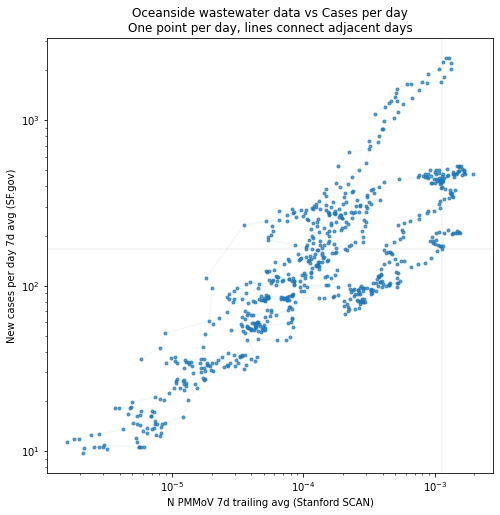

In [8]:
def _plot_ww_cases_scatter(figsize=None):

    rolling_cases = df_cases[["New Cases"]].rolling('7d', center=False).mean()

    df_joined = pd.DataFrame(data=rolling_cases["New Cases"])
    ns_colname = SEWAGE_KEY
    df_joined = df_joined.join(df_wastewater[ns_colname],how="inner")
    
    _, ax = subplots(figsize=figsize)
    
    xvals = df_joined[ns_colname]
    yvals = df_joined["New Cases"]

    plot(xvals, yvals,'-', alpha=0.05)
    scatter(xvals, yvals, alpha=0.7, marker='.')

    xlabel(f"{SEWAGE_LABEL} (Stanford SCAN)")
    ylabel("New cases per day 7d avg (SF.gov)")
    title("Oceanside wastewater data vs Cases per day\nOne point per day, lines connect adjacent days")
    
    axvline(xvals[-1], color="grey", alpha=0.1)
    axhline(yvals[-1], color="grey", alpha=0.1)

    xscale("log")
    yscale("log")
    
    #return df_joined.tail()
    
_plot_ww_cases_scatter((8,8))

## Scatter plot: tests performed vs sewage levels

This is a scatter plot of cases versus sewage levels, using 7d trailing averages for each.  Both are on log scales due to the nature of the data; we expect to see a linear relationship between them, which we mostly do.  The exceptions are when testing is too low and cases are correspondingly under-reported.

There is a related scatter plot of Cases versus sewage levels below (`_plot_ww_cases_scatter()`).

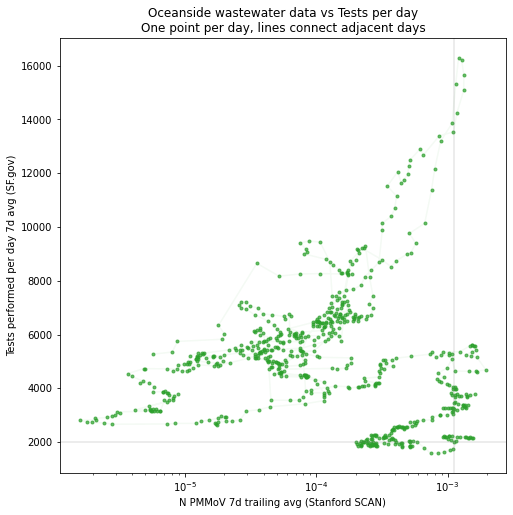

In [9]:
def _plot_ww_testing_scatter(figsize=None):
    col_y = "tests"
    label_y = "Tests performed per day 7d avg (SF.gov)"
    ns_colname = SEWAGE_KEY

    df_y = df_testing[[col_y]].rolling('7d', center=False).mean()

    df_joined = pd.DataFrame(data=df_y[col_y])
    df_joined = df_joined.join(df_wastewater[ns_colname],how="inner")

    df_joined
    _, ax = subplots(figsize=figsize)

    xvals = df_joined[ns_colname]
    yvals = df_joined[col_y]

    plot(xvals, yvals,'-', alpha=0.05, color=COLOR_TESTS)
    scatter(xvals, yvals, alpha=0.7, marker='.', color=COLOR_TESTS)

    xlabel(f"{SEWAGE_LABEL} (Stanford SCAN)")
    ylabel(label_y)
    title("Oceanside wastewater data vs Tests per day\nOne point per day, lines connect adjacent days")

    axvline(xvals[-1], color="grey", alpha=0.2)
    axhline(yvals[-1], color="grey", alpha=0.2)

    xscale("log")
    #yscale("log")
    
_plot_ww_testing_scatter((8,8))

# Longitudinal week-on-week case change

This plots the week-on-week change in case counts.  Note that it's not adjusted for week-on testing counts, so under-testing will result in apparent case declines.  Given that this is what you usually see in the headlines, don't blame this notebook for a bogus methodology.

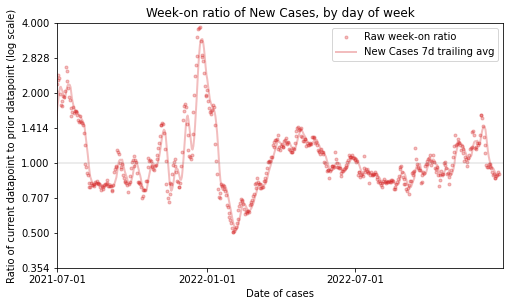

In [10]:
def _plot_week_on_cases_long(figsize=None, xtick_downsample=3, plot_points=True):
    '''Make a longitudinal plot of the week-on-week case growth
    
    It cannot be overemphasized that this data is contingent upon the testing
    rate, which is highly variable.  There are times when SF simply has 10%
    fewer tests for a few days at a stretch, for no apparent reason.  This
    will result in meaningful artifacts in the plots here.
    
    figsize: 0 to not create a figure, otherwise as in plt.figure()
    xtick_downsample: how hard to downsample the number of xticks
    plot_points: whether or not to plot the raw data points
    
    (matplotlib puts in too many xticks for twitter-friendly plots)
    
    We put power-of-root-two ticks on the y axis, to help assess the weekly
    growth rate.
    '''
    if 0 != figsize:
        figure(figsize=figsize)
    k = 7
    limdelta = 0.2*k

    i0 = 6  # Skip to the first monday

    colname = "New Cases"
    color = COLOR_CASES
    df_roll = df_cases[[colname]].rolling('7d', center=False).mean()

    
    rho_cases = np.log2(df_roll[colname].values[i0+k:]) - np.log2(df_roll[colname].values[i0:-k])
    rho_index = df_roll.index.values[i0+k:]

    #for i in range(7):
    #    dow = pd.to_datetime(rolling_cases.index.values[i0+k+i]).strftime("%a")
    #    plot(rho_index[i::7], rho_cases[i::7], '.-', alpha=0.2, label=dow, linewidth=2)
    if plot_points:
        plot(rho_index, rho_cases, '.', alpha=0.3, label="Raw week-on ratio", color=color)

    rho_df = pd.DataFrame({colname: rho_cases}, index=rho_index)
    rho_rolling = rho_df.rolling('7d', center=False)
    plot(rho_rolling[colname].mean(), '-', alpha=0.3, 
         label=f"{colname} 7d trailing avg", linewidth=2, color=color)

    axhline(0, color="grey", alpha=.2)
    legend(loc="upper right")
    
    xlim(pd.to_datetime('2021-07-01'), datetime.datetime.today())
    ylim(0-limdelta,limdelta*1.2)


    yts = yticks()
    yticks(yts[0], labels=[ f'{y:0.3f}' for y in 2**yts[0]]);

    title(f"Week-on ratio of {colname}, by day of week")
    ylabel("Ratio of current datapoint to prior datapoint (log scale)")
    xlabel("Date of cases")
    
    if xtick_downsample and xtick_downsample != 1:
        xtick_locs, xtick_texts = xticks()
        xticks(xtick_locs[::xtick_downsample])

_plot_week_on_cases_long()  

# Longitudinal week-on-week tests performed change

This plots the week-on-week change in tests performed.  This is useful when evaluating the week-on-week case counts, as it lets you assess whether the change in cases is real, or just reduced testing.  (Reduced testing may also be meaningful: when there are fewer actual cases, there will be fewer tests!  However, a few hiccups during the current BA.2 wave strongly suggests that reduced testing may just be that 10% fewer tests were given for a few days, for no apparent reason.)

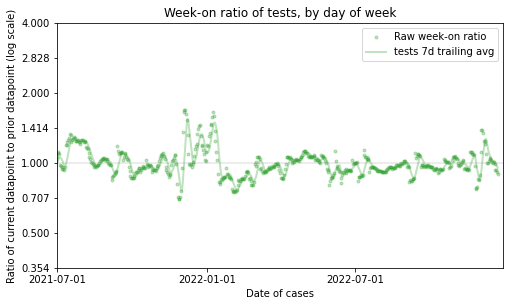

In [11]:
def _plot_week_on_tests_long(figsize=None, xtick_downsample=3, plot_points=True):    
    '''Make a longitudinal plot of the week-on-week tests-performed growth
    
    This allows you to see how the week-on testing rates compare.  This is
    useful to assess how meaningful the week-on case ratio is: if the tests
    are down, and the cases are down, well, maybe it's just that the tests
    are down.  This is irritatingly relevant to keep an eye on.
    
    figsize: 0 to not create a figure, otherwise as in plt.figure()
    xtick_downsample: how hard to downsample the number of xticks
    plot_points: whether or not to plot the raw data points
    
    (matplotlib puts in too many xticks for twitter-friendly plots)
    
    We put power-of-root-two ticks on the y axis, to help assess the weekly
    growth rate.
    '''
    if 0 != figsize:
        figure(figsize=figsize)
    k = 7
    limdelta = 0.2*k

    i0 = 6  # Skip to the first monday

    colname = "tests"
    color = COLOR_TESTS
    df_roll = df_testing[[colname]].rolling('7d', center=False).mean()

    
    rho_cases = np.log2(df_roll[colname].values[i0+k:]) - np.log2(df_roll[colname].values[i0:-k])
    rho_index = df_roll.index.values[i0+k:]

    if plot_points:
        plot(rho_index, rho_cases, '.', alpha=0.3, label="Raw week-on ratio", color=color)

    rho_df = pd.DataFrame({colname: rho_cases}, index=rho_index)
    rho_rolling = rho_df.rolling('7d', center=False)
    plot(rho_rolling[colname].mean(), '-', alpha=0.3, 
         label=f"{colname} 7d trailing avg", linewidth=2, color=color)

    axhline(0, color="grey", alpha=.2)
    legend(loc="upper right")
    
    xlim(pd.to_datetime('2021-07-01'), datetime.datetime.today())
    ylim(0-limdelta,limdelta*1.2)


    yts = yticks()
    yticks(yts[0], labels=[ f'{y:0.3f}' for y in 2**yts[0]]);

    title(f"Week-on ratio of {colname}, by day of week")
    ylabel("Ratio of current datapoint to prior datapoint (log scale)")
    xlabel("Date of cases")
    
    if xtick_downsample and xtick_downsample != 1:
        xtick_locs, xtick_texts = xticks()
        xticks(xtick_locs[::xtick_downsample])
        
_plot_week_on_tests_long()

Text(0.5, 1.0, 'Combined week-on ratios of tests and cases')

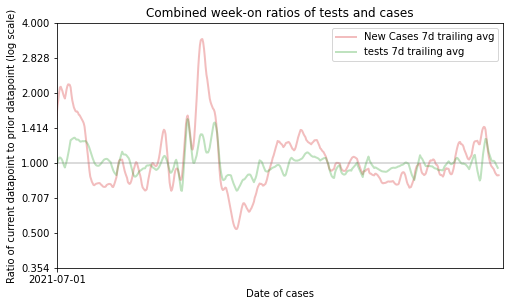

In [12]:
# And we can now combine these two into a single plot
_plot_week_on_cases_long(plot_points=False)
_plot_week_on_tests_long(figsize=0, plot_points=False)
title("Combined week-on ratios of tests and cases")

# Longitudinal week-on-week test positivity change

This plots the week-on-week change in tests positivity.  At times when cases exceed testing capacity, it's helpful to keep an eye on test positivity.  Looking at the week-on growth of the test positivity is useful to see how that is progressing.have

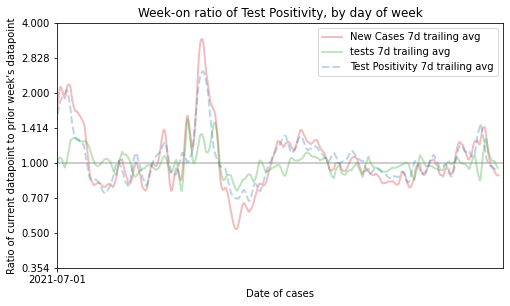

In [13]:
def _plot_week_on_test_pos_long(figsize=None, xtick_downsample=3, plot_points=True):
    
    '''Make a longitudinal plot of the week-on-week test positivity growth
    
    This allows you to see how the week-on test positivity compares.  When
    cases outstrip testing capacity, test positivity is a reasonable indicator
    of just how undersampled the cases might be.  It's unclear if the week-on
    ratio of this is particularly meaningful, but it's here for completeness.
    
    figsize: 0 to not create a figure, otherwise as in plt.figure()
    xtick_downsample: how hard to downsample the number of xticks
    plot_points: whether or not to plot the raw data points
    
    (matplotlib puts in too many xticks for twitter-friendly plots)
    
    We put power-of-root-two ticks on the y axis, to help assess the weekly
    growth rate.
    '''
    if 0 != figsize:
        figure(figsize=figsize)
    k = 7
    limdelta = 0.2*k

    i0 = 6  # Skip to the first monday

    df_roll = df_testing[["pos", "tests"]].rolling('7d', center=False).mean()
    df_roll["Test Positivity"] = df_roll["pos"]/df_roll["tests"]
    colname = "Test Positivity"
    color = "tab:blue"

    
    rho_cases = np.log2(df_roll[colname].values[i0+k:]) - np.log2(df_roll[colname].values[i0:-k])
    rho_index = df_roll.index.values[i0+k:]

    rho_cases = np.log2(df_roll[colname].values[i0+k:]) - np.log2(df_roll[colname].values[i0:-k])

    
    if plot_points:
        plot(rho_index, rho_cases, 'o', alpha=0.3, label="Raw week-on ratio", color=color)
        
    rho_df = pd.DataFrame({colname: rho_cases}, index=rho_index)
    rho_rolling = rho_df.rolling('7d', center=False)
    plot(rho_rolling[colname].mean(), '--', alpha=0.3, 
         label=f"{colname} 7d trailing avg", linewidth=2, color=color)

    axhline(0, color="grey", alpha=.2)
    legend(loc="upper right")
    
    xlim(pd.to_datetime('2021-07-01'), datetime.datetime.today())
    ylim(0-limdelta,limdelta*1.2)


    yts = yticks()
    yticks(yts[0], labels=[ f'{y:0.3f}' for y in 2**yts[0]]);

    title(f"Week-on ratio of {colname}, by day of week")
    ylabel("Ratio of current datapoint to prior week's datapoint")
    xlabel("Date of cases")
    
    if xtick_downsample and xtick_downsample != 1:
        xtick_locs, xtick_texts = xticks()
        xticks(xtick_locs[::xtick_downsample])
    
_plot_week_on_cases_long(plot_points=False)
_plot_week_on_tests_long(0, plot_points=False)
_plot_week_on_test_pos_long(0, plot_points=False)

# Raw Test Positivity rates

This plots the raw per-day test positivity rates.  As mentioned above, test postivity goes up a lot when cases grow faster than testing does.  It obviously goes up a bit at the beginning of waves, but when community spread really kicks in, test positivity goes way up.  In particular, when testing is explicitly or effectively rationed, you see sharp upticks.  This is seen in the initial wave, as well as very strongly during omicron.  We are seeing something not unlike this during the current BA.2 wave, but on a much slower burn.

(0.0, 22.0)

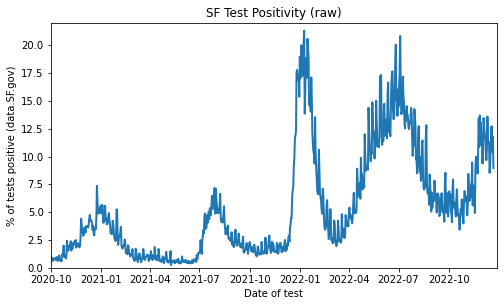

In [14]:
def _plot_testing_pos_rate():
    '''Plot the daily test positivity rate over time
    
    When case growth outstrips test capacity, test positivity goes up a lot.
    
    This plot allows you to keep an eye on that.  It plots raw per-day data,
    with no smoothing, as case growth tends to happen quickly enough that the
    weekly smoothing impacts the readability of the plot.
    
    Note that weekends and Mondays have higher test positivities in general,
    probably due to people only going in to get tested on the weekend if they
    really think they need to do it.  The actual test numbers are much lower
    on the weekends, which supports this bit of pop psychology by some random
    dude whose best psychological qualification is a BA in Linguistics.
    
    The x-axis is manually set from 2020-10-10 to today.
    '''
    tp_rate = df_testing.pos/df_testing["tests"]*100
    
    plot(tp_rate, '-', linewidth=2)
    xlim(pd.to_datetime("2020-10-01"), datetime.datetime.now())
    xlabel("Date of test")
    ylabel("% of tests positive (data.SF.gov)")
    title("SF Test Positivity (raw)")

_plot_testing_pos_rate()


ylim(0,22)  # Keep omicron from vertically compressing everything

# The daily dashboard

We now combine all the reported plots into a single place, so it's easy to copy-paste them into twitter.

This is the set of plots I was publishing for a while, but it may be relevant to swap them around for your application.

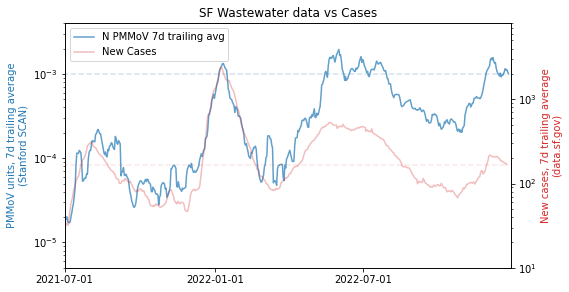

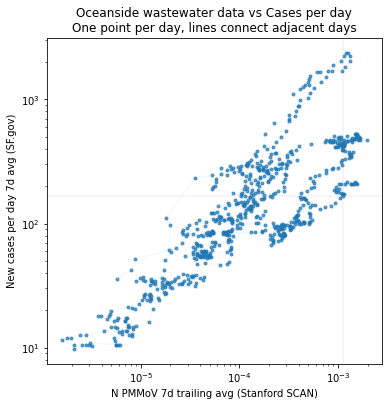

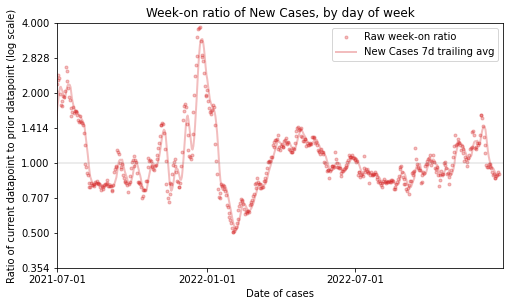

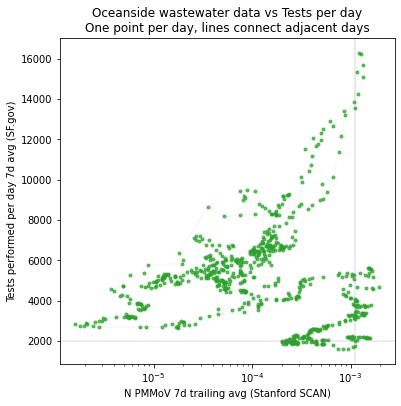

In [15]:
_plot_ww_cases_long()
_plot_ww_cases_scatter((6,6))
_plot_week_on_cases_long()
_plot_ww_testing_scatter((6,6))


(18567.0, 19354.507565151667)

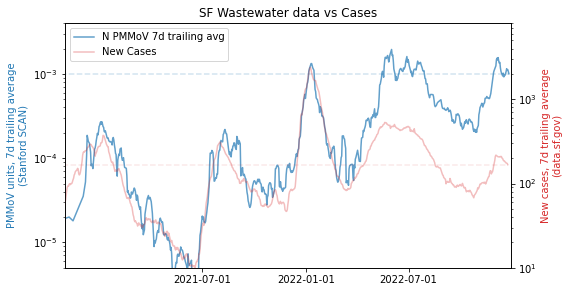

In [16]:
_plot_ww_cases_long()
xlim(pd.to_datetime("2020-11-01"), datetime.datetime.now())

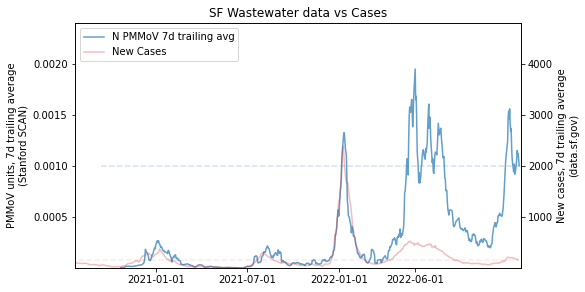

In [17]:
def _plot_ww_cases_long_linear(plot_dots = False, figsize=None, ax1=None, xtick_downsample=3):
    '''Dirty hack: linear version of the wastewater/cases plot
    
    
    Please see _plot_ww_cases_long() for the documentation of this this one.
    
    This only exists because the axes are not exposed after the plot is made, so we can't
    switch from log y axes to linear after the fact.
    '''
    
    
    from matplotlib.pyplot import xlim, title, xlabel, ylabel, legend, xticks
    if ax1 is None:
        _, ax1 = plt.subplots(figsize=figsize)

    ns_colname = SEWAGE_KEY

    wwdata = df_wastewater[ns_colname] # .S_PMMoV_rtrimmed7+df_wastewater.N_PMMoV_rtrimmed7
    ln1 = ax1.plot(wwdata, alpha=0.7, label=SEWAGE_LABEL, color=COLOR_WW)

    if plot_dots:
        ax1.plot(df_wastewater[SEWAGE_RAW], '.', alpha=0.2, color=COLOR_WW)

    ax1.set_ylabel("PMMoV units, 7d trailing average\n(Stanford SCAN)")
    ax1.hlines(wwdata[-1], xlim()[0], wwdata.index[-1],linestyle='--', color=COLOR_WW, alpha=0.2)
    
    # Get second axis and plot
    ax2 = ax1.twinx()
  
    rolling_cases = df_cases[["New Cases"]].rolling('7d', center=False).mean()
    ln3 = ax2.plot(rolling_cases["New Cases"], '-', color=COLOR_CASES, label="New Cases", alpha=0.3)

    if plot_dots:
        ln4 = ax2.plot(df_cases["New Cases"], 'o', color=COLOR_CASES, label="New Cases", alpha=0.1)

    ax2.hlines(rolling_cases["New Cases"][-1], xlim()[0], rolling_cases.index[-1],
               linestyle='--', color=COLOR_CASES, alpha=0.1)

    ax2.set_ylabel("New cases, 7d trailing average\n(data.sf.gov)")

    lns = ln1+ln3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper left")

    x0,x1 = xlim()
    xlim(pd.to_datetime("2021-07-01"), df_wastewater.dt[-1]+pd.Timedelta(3, unit="d"))

    # Touchups
    ymax_scale = 1.2
    ax1.set_ylim(5e-6,2e-3*ymax_scale)
    ax2.set_ylim(10,4e3*ymax_scale)
    
    #ax1.set_yscale("log")
    #ax2.set_yscale("log")

    title("SF Wastewater data vs Cases")
    xlabel("Date")

    if xtick_downsample and xtick_downsample != 1:
        xtick_locs, xtick_texts = xticks()
        xticks(xtick_locs[::xtick_downsample])
        
    return df_wastewater.dt[-1]+pd.Timedelta(3, unit="d")
    
_plot_ww_cases_long_linear(plot_dots=False)

# Draw in the last day of school
if False:
    end_sfusd = pd.to_datetime("2022-06-01")
    end_sfusd_color = "#ff6666"
    axvline(end_sfusd, alpha=0.3, color=end_sfusd_color)
    text(end_sfusd-datetime.timedelta(days=4), 4000,
         "Last day of school (SFUSD)", 
         horizontalalignment="right", color=end_sfusd_color)

# Summer camp viz
if False:
    camp_start = pd.to_datetime("2022-06-06")
    dweek = datetime.timedelta(days=7)
    spanwidth = datetime.timedelta(days=2)
    offset = datetime.timedelta(days=3+2)
    for i in range(10):
        d0 = camp_start + offset + i*dweek
        d1 = d0 + spanwidth
        axvspan(d0, d1, color="grey", alpha=0.1)

    # Twiddle the bounds to gut-check fit by eyeball
    xlim(pd.to_datetime("2022-05-15"), datetime.datetime.today())

# Wave viz
if False:
    xlim(pd.to_datetime('2020-07-23'), datetime.datetime.now())
    xticks(list(map(pd.to_datetime, ["2021-01-01","2021-07-01", "2022-01-01", "2022-06-01"])))
    
    if True:
        _vline(pd.to_datetime('2022-01-11'), 3000, "Omicron", "#448")
        _vline(pd.to_datetime('2021-08-11'), 3000, "Delta", "#484")
        _vline(pd.to_datetime('2021-01-11'), 3000, "WT", "#844")
    else:
        _vspan(pd.to_datetime('2022-07-04'), pd.to_datetime('2022-08-28'),4500, "o BA.5", "#8cc")
        _vspan(pd.to_datetime('2021-12-20'), pd.to_datetime('2022-03-28'),3000, "Omicron BA.1", "#88c")
        _vspan(pd.to_datetime('2021-06-28'), pd.to_datetime('2021-09-20'),3000, "Delta", "#8c8")
        _vspan(pd.to_datetime('2020-11-24'), pd.to_datetime('2021-03-28'),3000, "WT", "#c88")
        
if True:
    xlim(pd.to_datetime('2020-07-23'), datetime.datetime.now())
    xticks(list(map(pd.to_datetime, ["2021-01-01","2021-07-01", "2022-01-01", "2022-06-01"])))

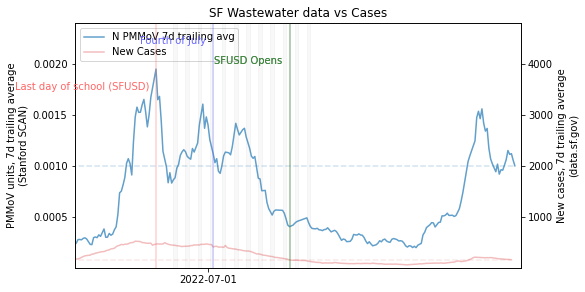

In [18]:
_plot_ww_cases_long_linear(plot_dots=False)
# Draw in the last day of school

end_sfusd = pd.to_datetime("2022-06-01")
end_sfusd_color = "#ff6666"
#axvline(end_sfusd, alpha=0.3, color=end_sfusd_color)
#text(end_sfusd-datetime.timedelta(days=4), 4000,
#     "Last day of school (SFUSD)", 
#     horizontalalignment="right", color=end_sfusd_color)

_vline(end_sfusd, 3500, "Last day of school (SFUSD)", "#ff6666")

_vline(pd.to_datetime("2022-07-04"), 4400, "Fourth of July", "#6666ff")

#_vline(pd.to_datetime("2022-07-17"), 4000, "7/17", "#ccc")
_vline(pd.to_datetime("2022-08-17"), 4000, "SFUSD Opens", "#484")


_vline(pd.to_datetime("2022-08-17"), 4000, "SFUSD Opens", "#484")


if True:

    camp_start = pd.to_datetime("2022-06-06")
    dweek = datetime.timedelta(days=7)
    spanwidth = datetime.timedelta(days=2)
    offset = datetime.timedelta(days=3+2)
    
    for i in range(12):
        d0 = camp_start + offset + i*dweek
        d1 = d0 + spanwidth
        axvspan(d0, d1, color="grey", alpha=0.05)

    # Twiddle the bounds to gut-check fit by eyeball
    xlim(pd.to_datetime("2022-04-15"), datetime.datetime.today())

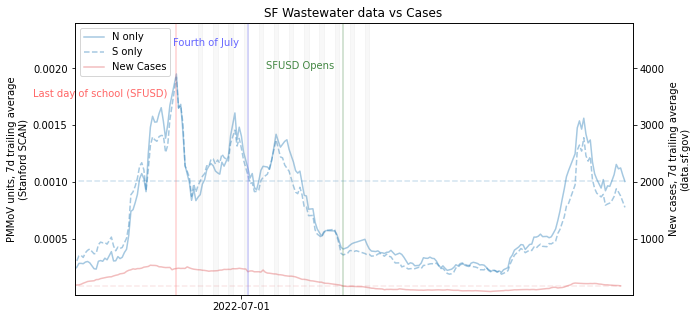

In [19]:
def _plot_bothww_cases_long_linear(plot_dots = False, figsize=None, ax1=None, xtick_downsample=3):
    '''Dirty hack: linear version of the wastewater/cases plot
    
    
    Please see _plot_ww_cases_long() for the documentation of this this one.
    
    This only exists because the axes are not exposed after the plot is made, so we can't
    switch from log y axes to linear after the fact.
    '''
    if ax1 is None:
        _, ax1 = plt.subplots(figsize=figsize)

    ns_colname = SEWAGE_KEY

    wwdata = df_wastewater[ns_colname] # .S_PMMoV_rtrimmed7+df_wastewater.N_PMMoV_rtrimmed7
    ln1 = ax1.plot(df_wastewater["rr_n_rolling3"], alpha=0.4, label="N only", color=COLOR_WW)
    #ln1_2 = ax1.plot(df_wastewater["ns_mean_rtrimmed7"], '--', alpha=0.4, label="N+S", color=COLOR_WW)
    ln1_2 = ax1.plot(df_wastewater["rr_s_rolling3"], '--', alpha=0.4, label="S only", color=COLOR_WW)

    if plot_dots:
        ax1.plot(df_wastewater[SEWAGE_RAW], '.', alpha=0.2, color=COLOR_WW)

    ax1.set_ylabel("PMMoV units, 7d trailing average\n(Stanford SCAN)")
    ax1.hlines(wwdata[-1], xlim()[0], wwdata.index[-1],linestyle='--', color=COLOR_WW, alpha=0.2)
    
    # Get second axis and plot
    ax2 = ax1.twinx()
  
    rolling_cases = df_cases[["New Cases"]].rolling('7d', center=False).mean()
    ln3 = ax2.plot(rolling_cases["New Cases"], '-', color=COLOR_CASES, label="New Cases", alpha=0.3)

    if plot_dots:
        ln4 = ax2.plot(df_cases["New Cases"], 'o', color=COLOR_CASES, label="New Cases", alpha=0.1)

    ax2.hlines(rolling_cases["New Cases"][-1], xlim()[0], rolling_cases.index[-1],
               linestyle='--', color=COLOR_CASES, alpha=0.1)

    ax2.set_ylabel("New cases, 7d trailing average\n(data.sf.gov)")

    lns = ln1+ln1_2+ln3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper left")

    x0,x1 = xlim()
    xlim(pd.to_datetime("2021-07-01"), df_wastewater.dt[-1]+pd.Timedelta(3, unit="d"))

    # Touchups
    ymax_scale = 1.2
    ax1.set_ylim(5e-6,2e-3*ymax_scale)
    ax2.set_ylim(10,4e3*ymax_scale)
    
    #ax1.set_yscale("log")
    #ax2.set_yscale("log")

    title("SF Wastewater data vs Cases")
    xlabel("Date")

    if xtick_downsample and xtick_downsample != 1:
        xtick_locs, xtick_texts = xticks()
        xticks(xtick_locs[::xtick_downsample])
        
    return df_wastewater.dt[-1]+pd.Timedelta(3, unit="d")
    
_plot_bothww_cases_long_linear(plot_dots=False, figsize=(10,5))

# Draw in the last day of school

end_sfusd = pd.to_datetime("2022-06-01")
end_sfusd_color = "#ff6666"
#axvline(end_sfusd, alpha=0.3, color=end_sfusd_color)
#text(end_sfusd-datetime.timedelta(days=4), 4000,
#     "Last day of school (SFUSD)", 
#     horizontalalignment="right", color=end_sfusd_color)

_vline(end_sfusd, 3500, "Last day of school (SFUSD)", "#ff6666")

_vline(pd.to_datetime("2022-07-04"), 4400, "Fourth of July", "#6666ff")

#_vline(pd.to_datetime("2022-07-17"), 4000, "7/17", "#ccc")
_vline(pd.to_datetime("2022-08-17"), 4000, "SFUSD Opens", "#484")


if True:

    camp_start = pd.to_datetime("2022-06-06")
    dweek = datetime.timedelta(days=7)
    spanwidth = datetime.timedelta(days=2)
    offset = datetime.timedelta(days=3+2)
    
    for i in range(12):
        d0 = camp_start + offset + i*dweek
        d1 = d0 + spanwidth
        axvspan(d0, d1, color="grey", alpha=0.05)

    # Twiddle the bounds to gut-check fit by eyeball
    xlim(pd.to_datetime("2022-04-15"), datetime.datetime.today())

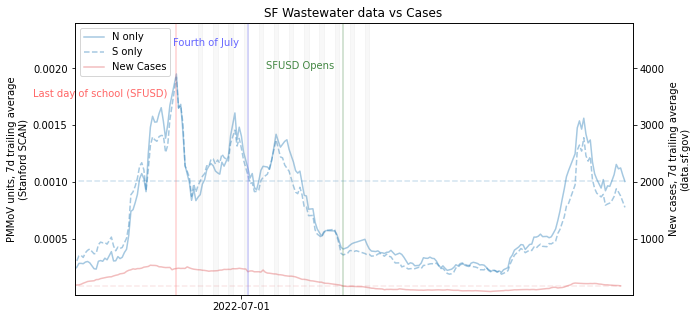

In [20]:
  
_plot_bothww_cases_long_linear(plot_dots=False, figsize=(10,5))

# Draw in the last day of school

end_sfusd = pd.to_datetime("2022-06-01")
end_sfusd_color = "#ff6666"
#axvline(end_sfusd, alpha=0.3, color=end_sfusd_color)
#text(end_sfusd-datetime.timedelta(days=4), 4000,
#     "Last day of school (SFUSD)", 
#     horizontalalignment="right", color=end_sfusd_color)

_vline(end_sfusd, 3500, "Last day of school (SFUSD)", "#ff6666")

_vline(pd.to_datetime("2022-07-04"), 4400, "Fourth of July", "#6666ff")

#_vline(pd.to_datetime("2022-07-17"), 4000, "7/17", "#ccc")
_vline(pd.to_datetime("2022-08-17"), 4000, "SFUSD Opens", "#484")


if True:

    camp_start = pd.to_datetime("2022-06-06")
    dweek = datetime.timedelta(days=7)
    spanwidth = datetime.timedelta(days=2)
    offset = datetime.timedelta(days=3+2)
    
    for i in range(12):
        d0 = camp_start + offset + i*dweek
        d1 = d0 + spanwidth
        axvspan(d0, d1, color="grey", alpha=0.05)

    # Twiddle the bounds to gut-check fit by eyeball
    xlim(pd.to_datetime("2022-04-15"), datetime.datetime.today())

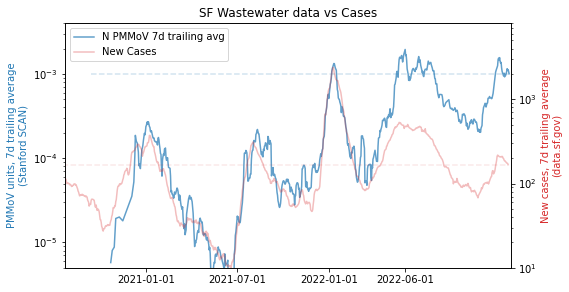

In [23]:
_plot_ww_cases_long(figsize=(8,4.5))
xlim(pd.to_datetime('2020-07-23'), datetime.datetime.now())
xticks(list(map(pd.to_datetime, ["2021-01-01","2021-07-01", "2022-01-01", "2022-06-01"])));

That's it.  That's the dashboard. 

Now go be responsible, thoughtful members of society with the insight you've gained.

And wear a fucking mask.